## PROBLEM SET 1 - TAKE AT HOME (25 POINTS)

**You will lose all corresponding points if we can't access the implementation notebook URL or the Github URL. We will NOT message you. Do NOT invite the TAs to your Github repo (option 2 below) EARLIER than the morning of the day of the exam, since invites expire in 7 days.** 

## Introduction

In the last few years, the field of generative modeling has seen a lot of progress. The techniques that have been developed in this field are very useful for other tasks such as semi-supervised learning, representation learning, and reinforcement learning. In this problem statement we attempt to prepare you to understand the basics of a technique that has been very successful in generative modeling: Variational Autoencoders (VAEs). Understanding VAEs is  the key for you to get a head start with more advanced models such as [Stable Diffusion that are all the rage these days](https://clipdrop.co/stable-diffusion-turbo). 



## Task 1: Study what VAEs are and how they work (0 points)

Consult this [blog post](https://jaan.io/what-is-variational-autoencoder-vae-tutorial/) and its [2D VAE autoencoder implemenation for the MNIST dataset](https://github.com/jaanli/variational-autoencoder). 

## Task 2: Replicate the VAE for the MNIST dataset (25 points)

Implement the VAE model for the MNIST dataset and train it ensuring that you plot the loss curves for the training and validation sets and perform hyperparameter optimization on the size of the latent space as well as on the optimizer parameters. To all points you need to include as comments in the code or as markdown cells what each function in the code is doing. Don't be frugal in your commentary. (15 points)

Replicate the figure showing the final latent variable space shown below. Note that you will not produce the animated figure shown below but show only the final latent space $(z_1, z_2)$. (5 points)

Show VAE generated images for all digits 0-9 after model training. (5 points)

![](latent-variables.gif)

You have two implementation options: (1) All in one notebook (2) Github repo. 

### Option 1: All in one Colab notebook

You submit a single Colab notebook URL that contains all the code and the outputs. Your notebook should be self-contained and can be launched in Google Colab using a corresponding button at the top of the notebook. See the regression notebook in the course site for an example of such button. You **need to save all outputs in the notebook** so that the TAs can check that your code is working properly. 

### Option 2: Github repo 

If you prefer to work without notebooks, with containers or not, you can submit the implementation python scripts and version control your code in a private Github repo. You have to submit the Github URL and clearly document the way to launch the runtime / install requirements.txt and include all required figures in the README.md file. 

IMPORTANT: Ensure that the github repo remains private. If you submit a public github repo you will be held responsible for violating the honor code.

# Some libraries we need to use, we first import these libraries

In [1]:
import urllib.request
import os
import h5py
import numpy as np
import random
import time
import matplotlib.pyplot as plt

import torch
import torch.utils
import torch.utils.data
from torch import nn
from torch.nn import functional as F

import pathlib

# Dataset downloader and dataloader

- Reference: [link](https://github.com/jaanli/variational-autoencoder/blob/master/data.py)


In [2]:
def parse_binary_mnist(data_dir):
    def lines_to_np_array(lines):
        return np.array([[int(i) for i in line.split()] for line in lines])

    with open(os.path.join(data_dir, "binarized_mnist_train.amat")) as f:
        lines = f.readlines()
    train_data = lines_to_np_array(lines).astype("float32")
    with open(os.path.join(data_dir, "binarized_mnist_valid.amat")) as f:
        lines = f.readlines()
    validation_data = lines_to_np_array(lines).astype("float32")
    with open(os.path.join(data_dir, "binarized_mnist_test.amat")) as f:
        lines = f.readlines()
    test_data = lines_to_np_array(lines).astype("float32")
    return train_data, validation_data, test_data


def download_binary_mnist(fname):
    data_dir = "/tmp/"
    subdatasets = ["train", "valid", "test"]
    for subdataset in subdatasets:
        filename = "binarized_mnist_{}.amat".format(subdataset)
        url = "http://www.cs.toronto.edu/~larocheh/public/datasets/binarized_mnist/binarized_mnist_{}.amat".format(
            subdataset
        )
        local_filename = os.path.join(data_dir, filename)
        urllib.request.urlretrieve(url, local_filename)

    train, validation, test = parse_binary_mnist(data_dir)

    data_dict = {"train": train, "valid": validation, "test": test}
    f = h5py.File(fname, "w")
    f.create_dataset("train", data=data_dict["train"])
    f.create_dataset("valid", data=data_dict["valid"])
    f.create_dataset("test", data=data_dict["test"])
    f.close()
    print(f"Saved binary MNIST data to: {fname}")


def load_binary_mnist(fname, batch_size, test_batch_size, use_gpu):
    f = h5py.File(fname, "r")
    x_train = f["train"][::]
    x_val = f["valid"][::]
    x_test = f["test"][::]
    train = torch.utils.data.TensorDataset(torch.from_numpy(x_train))
    kwargs = {"num_workers": 4, "pin_memory": True} if use_gpu else {}
    train_loader = torch.utils.data.DataLoader(
        train, batch_size=batch_size, shuffle=True, **kwargs
    )
    validation = torch.utils.data.TensorDataset(torch.from_numpy(x_val))
    val_loader = torch.utils.data.DataLoader(
        validation, batch_size=test_batch_size, shuffle=False, **kwargs
    )
    test = torch.utils.data.TensorDataset(torch.from_numpy(x_test))
    test_loader = torch.utils.data.DataLoader(
        test, batch_size=test_batch_size, shuffle=False, **kwargs
    )
    return train_loader, val_loader, test_loader

# Some components from masks.py

- Reference: [link](https://github.com/jaanli/variational-autoencoder/blob/master/masks.py)


In [3]:
def create_input_order(input_size, input_order="left-to-right"):
    """Returns a degree vectors for the input."""
    if input_order == "left-to-right":
        return np.arange(start=1, stop=input_size + 1)
    elif input_order == "right-to-left":
        return np.arange(start=input_size, stop=0, step=-1)
    elif input_order == "random":
        ret = np.arange(start=1, stop=input_size + 1)
        np.random.shuffle(ret)
        return ret


def create_degrees(
    input_size, hidden_units, input_order="left-to-right", hidden_degrees="equal"
):
    input_order = create_input_order(input_size, input_order)
    degrees = [input_order]
    for units in hidden_units:
        if hidden_degrees == "random":
            # samples from: [low, high)
            degrees.append(
                np.random.randint(
                    low=min(np.min(degrees[-1]), input_size - 1),
                    high=input_size,
                    size=units,
                )
            )
        elif hidden_degrees == "equal":
            min_degree = min(np.min(degrees[-1]), input_size - 1)
            degrees.append(
                np.maximum(
                    min_degree,
                    # Evenly divide the range `[1, input_size - 1]` in to `units + 1`
                    # segments, and pick the boundaries between the segments as degrees.
                    np.ceil(
                        np.arange(1, units + 1) * (input_size - 1) / float(units + 1)
                    ).astype(np.int32),
                )
            )
    return degrees


def create_masks(degrees):
    """Returns a list of binary mask matrices enforcing autoregressivity."""
    return [
        # Create input->hidden and hidden->hidden masks.
        inp[:, np.newaxis] <= out
        for inp, out in zip(degrees[:-1], degrees[1:])
    ] + [
        # Create hidden->output mask.
        degrees[-1][:, np.newaxis]
        < degrees[0]
    ]


def check_masks(masks):
    """Check that the connectivity matrix between layers is lower triangular."""
    # (num_input, num_hidden)
    prev = masks[0].t()
    for i in range(1, len(masks)):
        # num_hidden is second axis
        prev = prev @ masks[i].t()
    final = prev.numpy()
    num_input = masks[0].shape[1]
    num_output = masks[-1].shape[0]
    assert final.shape == (num_input, num_output)
    if num_output == num_input:
        assert np.triu(final).all() == 0
    else:
        for submat in np.split(
            final, indices_or_sections=num_output // num_input, axis=1
        ):
            assert np.triu(submat).all() == 0


def build_random_masks(num_input, num_output, num_hidden, num_layers):
    """Build the masks according to Eq 12 and 13 in the MADE paper."""
    # assign input units a number between 1 and D
    rng = np.random.RandomState(0)
    m_list, masks = [], []
    m_list.append(np.arange(1, num_input + 1))
    for i in range(1, num_layers + 1):
        if i == num_layers:
            # assign output layer units a number between 1 and D
            m = np.arange(1, num_input + 1)
            assert (
                num_output % num_input == 0
            ), "num_output must be multiple of num_input"
            m_list.append(np.hstack([m for _ in range(num_output // num_input)]))
        else:
            # assign hidden layer units a number between 1 and D-1
            # i.e. randomly assign maximum number of input nodes to connect to
            m_list.append(rng.randint(1, num_input, size=num_hidden))
        if i == num_layers:
            mask = m_list[i][None, :] > m_list[i - 1][:, None]
        else:
            # input to hidden & hidden to hidden
            mask = m_list[i][None, :] >= m_list[i - 1][:, None]
        # need to transpose for torch linear layer, shape (num_output, num_input)
        masks.append(mask.astype(np.float32).T)
    return masks


def _compute_neighborhood(system_size):
    """Compute (system_size, neighborhood_size) array."""
    num_variables = system_size ** 2
    arange = np.arange(num_variables)
    grid = arange.reshape((system_size, system_size))
    self_and_neighbors = np.zeros((system_size, system_size, 5), dtype=int)
    # four nearest-neighbors
    self_and_neighbors = np.zeros((system_size, system_size, 5), dtype=int)
    self_and_neighbors[..., 0] = grid
    neighbor_index = 1
    for axis in [0, 1]:
        for shift in [-1, 1]:
            self_and_neighbors[..., neighbor_index] = np.roll(
                grid, shift=shift, axis=axis
            )
            neighbor_index += 1
    # reshape to (num_latent, num_neighbors)
    self_and_neighbors = self_and_neighbors.reshape(num_variables, -1)
    return self_and_neighbors


def build_neighborhood_indicator(system_size):
    """Boolean indicator of (num_variables, num_variables) for whether nodes are neighbors."""
    neighborhood = _compute_neighborhood(system_size)
    num_variables = system_size ** 2
    mask = np.zeros((num_variables, num_variables), dtype=bool)
    for i in range(len(mask)):
        mask[i, neighborhood[i]] = True
    return mask


def build_deterministic_mask(num_variables, num_input, num_output, mask_type):
    if mask_type == "input":
        in_degrees = np.arange(num_input) % num_variables
    else:
        in_degrees = np.arange(num_input) % (num_variables - 1)

    if mask_type == "output":
        out_degrees = np.arange(num_output) % num_variables
        mask = np.expand_dims(out_degrees, -1) > np.expand_dims(in_degrees, 0)
    else:
        out_degrees = np.arange(num_output) % (num_variables - 1)
        mask = np.expand_dims(out_degrees, -1) >= np.expand_dims(in_degrees, 0)

    return mask, in_degrees, out_degrees


def build_masks(num_variables, num_input, num_output, num_hidden, mask_fn):
    input_mask, _, _ = mask_fn(num_variables, num_input, num_hidden, "input")
    hidden_mask, _, _ = mask_fn(num_variables, num_hidden, num_hidden, "hidden")
    output_mask, _, _ = mask_fn(num_variables, num_hidden, num_output, "output")
    masks = [input_mask, hidden_mask, output_mask]
    masks = [torch.from_numpy(x.astype(np.float32)) for x in masks]
    return masks


def build_neighborhood_mask(num_variables, num_input, num_output, mask_type):
    system_size = int(np.sqrt(num_variables))
    # return context mask for input, with same assignment of m(k) maximum node degree
    mask, in_degrees, out_degrees = build_deterministic_mask(
        system_size ** 2, num_input, num_output, mask_type
    )
    neighborhood = _compute_neighborhood(system_size)
    neighborhood_mask = np.zeros_like(mask)  # shape len(out_degrees), len(in_degrees)
    for i in range(len(neighborhood_mask)):
        neighborhood_indicator = np.isin(in_degrees, neighborhood[out_degrees[i]])
        neighborhood_mask[i, neighborhood_indicator] = True
    return mask * neighborhood_mask, in_degrees, out_degrees


def checkerboard(shape):
    return (np.indices(shape).sum(0) % 2).astype(np.float32)


# Some components from flow.py

- Reference: [link](https://github.com/jaanli/variational-autoencoder/blob/master/flow.py)


In [4]:
class InverseAutoregressiveFlow(nn.Module):
    """Inverse Autoregressive Flows with LSTM-type update. One block.

    Eq 11-14 of https://arxiv.org/abs/1606.04934
    """

    def __init__(self, num_input, num_hidden, num_context):
        super().__init__()
        self.made = MADE(
            num_input=num_input,
            num_outputs_per_input=2,
            num_hidden=num_hidden,
            num_context=num_context,
        )
        # init such that sigmoid(s) is close to 1 for stability
        self.sigmoid_arg_bias = nn.Parameter(torch.ones(num_input) * 2)
        self.sigmoid = nn.Sigmoid()
        self.log_sigmoid = nn.LogSigmoid()

    def forward(self, input, context=None):
        m, s = torch.chunk(self.made(input, context), chunks=2, dim=-1)
        s = s + self.sigmoid_arg_bias
        sigmoid = self.sigmoid(s)
        z = sigmoid * input + (1 - sigmoid) * m
        return z, -self.log_sigmoid(s)


class FlowSequential(nn.Sequential):
    """Forward pass."""

    def forward(self, input, context=None):
        total_log_prob = torch.zeros_like(input, device=input.device)
        for block in self._modules.values():
            input, log_prob = block(input, context)
            total_log_prob += log_prob
        return input, total_log_prob


class MaskedLinear(nn.Module):
    """Linear layer with some input-output connections masked."""

    def __init__(
        self, in_features, out_features, mask, context_features=None, bias=True
    ):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features, bias)
        self.register_buffer("mask", mask)
        if context_features is not None:
            self.cond_linear = nn.Linear(context_features, out_features, bias=False)

    def forward(self, input, context=None):
        output = F.linear(input, self.mask * self.linear.weight, self.linear.bias)
        if context is None:
            return output
        else:
            return output + self.cond_linear(context)


class MADE(nn.Module):
    """Implements MADE: Masked Autoencoder for Distribution Estimation.

    Follows https://arxiv.org/abs/1502.03509

    This is used to build MAF: Masked Autoregressive Flow (https://arxiv.org/abs/1705.07057).
    """

    def __init__(self, num_input, num_outputs_per_input, num_hidden, num_context):
        super().__init__()
        # m corresponds to m(k), the maximum degree of a node in the MADE paper
        self._m = []
        degrees = create_degrees(
            input_size=num_input,
            hidden_units=[num_hidden] * 2,
            input_order="left-to-right",
            hidden_degrees="equal",
        )
        self._masks = create_masks(degrees)
        self._masks[-1] = np.hstack(
            [self._masks[-1] for _ in range(num_outputs_per_input)]
        )
        self._masks = [torch.from_numpy(m.T) for m in self._masks]
        modules = []
        self.input_context_net = MaskedLinear(
            num_input, num_hidden, self._masks[0], num_context
        )
        self.net = nn.Sequential(
            nn.ReLU(),
            MaskedLinear(num_hidden, num_hidden, self._masks[1], context_features=None),
            nn.ReLU(),
            MaskedLinear(
                num_hidden,
                num_outputs_per_input * num_input,
                self._masks[2],
                context_features=None,
            ),
        )

    def forward(self, input, context=None):
        # first hidden layer receives input and context
        hidden = self.input_context_net(input, context)
        # rest of the network is conditioned on both input and context
        return self.net(hidden)


class Reverse(nn.Module):
    """An implementation of a reversing layer from
    Density estimation using Real NVP
    (https://arxiv.org/abs/1605.08803).

    From https://github.com/ikostrikov/pytorch-flows/blob/master/main.py
    """

    def __init__(self, num_input):
        super(Reverse, self).__init__()
        self.perm = np.array(np.arange(0, num_input)[::-1])
        self.inv_perm = np.argsort(self.perm)

    def forward(self, inputs, context=None, mode="forward"):
        if mode == "forward":
            return inputs[:, :, self.perm], torch.zeros_like(
                inputs, device=inputs.device
            )
        elif mode == "inverse":
            return inputs[:, :, self.inv_perm], torch.zeros_like(
                inputs, device=inputs.device
            )
        else:
            raise ValueError("Mode must be one of {forward, inverse}.")


# Main components of the model, from train_variational_autoencoder_pytorch.py

- Reference: [link](https://github.com/jaanli/variational-autoencoder/blob/master/train_variational_autoencoder_pytorch.py)
- Modifies: We added a decode method to the `Model` class and used nn to generate images from a given latent space.

In [5]:
class NormalLogProb(nn.Module):
    def __init__(self):
        super(NormalLogProb, self).__init__()

    def forward(self, loc, scale, z):
        var = torch.pow(scale, 2)
        return -0.5 * torch.log(2 * np.pi * var) - torch.pow(z - loc, 2) / (2 * var)


class BernoulliLogProb(nn.Module):
    def __init__(self):
        super(BernoulliLogProb, self).__init__()
        self.bce_with_logits = nn.BCEWithLogitsLoss(reduction="none")

    def forward(self, logits, target):
        return -self.bce_with_logits(logits, target)


class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(NeuralNetwork, self).__init__()
        modules = [
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        ]
        self.net = nn.Sequential(*modules)

    def forward(self, input):
        return self.net(input)


class VariationalMeanField(nn.Module):
    def __init__(self, latent_size, data_size):
        super(VariationalMeanField, self).__init__()
        self.inference_network = NeuralNetwork(
            input_size=data_size,
            output_size=latent_size * 2,
            hidden_size=latent_size * 2,
        )
        self.log_q_z = NormalLogProb()
        self.softplus = nn.Softplus()

    def forward(self, x, n_samples=1):
        loc, scale_arg = torch.chunk(
            self.inference_network(x).unsqueeze(1), chunks=2, dim=-1
        )
        scale = self.softplus(scale_arg)
        eps = torch.randn((loc.shape[0], n_samples, loc.shape[-1]), device=loc.device)
        z = loc + scale * eps
        log_q_z = self.log_q_z(loc, scale, z).sum(-1, keepdim=True)
        return z, log_q_z


class VariationalFlow(nn.Module):
    def __init__(self, latent_size, data_size, flow_depth):
        super(VariationalFlow, self).__init__()
        hidden_size = latent_size * 2
        self.inference_network = NeuralNetwork(
            input_size=data_size,
            output_size=latent_size * 3,
            hidden_size=hidden_size,
        )
        modules = []
        for _ in range(flow_depth):
            modules.append(
                InverseAutoregressiveFlow(
                    num_input=latent_size,
                    num_hidden=hidden_size,
                    num_context=latent_size,
                )
            )
            modules.append(Reverse(latent_size))
        self.q_z_flow = FlowSequential(*modules)
        self.log_q_z_0 = NormalLogProb()
        self.softplus = nn.Softplus()

    def forward(self, x, n_samples=1):
        loc, scale_arg, h = torch.chunk(
            self.inference_network(x).unsqueeze(1), chunks=3, dim=-1
        )
        scale = self.softplus(scale_arg)
        eps = torch.randn((loc.shape[0], n_samples, loc.shape[-1]), device=loc.device)
        z_0 = loc + scale * eps
        log_q_z_0 = self.log_q_z_0(loc, scale, z_0)
        z_t, log_q_z_flow = self.q_z_flow(z_0, context=h)
        log_q_z = (log_q_z_0 + log_q_z_flow).sum(-1, keepdim=True)
        return z_t, log_q_z


class Model(nn.Module):
    def __init__(self, latent_size, data_size):
        super(Model, self).__init__()
        self.register_buffer("p_z_loc", torch.zeros(latent_size))
        self.register_buffer("p_z_scale", torch.ones(latent_size))
        self.log_p_z = NormalLogProb()
        self.log_p_x = BernoulliLogProb()
        self.generative_network = NeuralNetwork(
            input_size=latent_size,
            output_size=data_size,
            hidden_size=latent_size * 2,
        )

    def forward(self, z, x):
        log_p_z = self.log_p_z(self.p_z_loc, self.p_z_scale, z).sum(-1, keepdim=True)
        logits = self.generative_network(z)
        logits, x = torch.broadcast_tensors(logits, x.unsqueeze(1))
        log_p_x = self.log_p_x(logits, x).sum(-1, keepdim=True)
        return log_p_z + log_p_x

    def decode(self, z):
        logits = self.generative_network(z)
        return logits


# Helper functions

- `evaluate`: We made some modifications based on the original function. We record the loss of each batch. The reason why we do not record the loss of the entire `eval_data` is that there are too few recording points, and the loss curve drawn in this way is not smooth enough.

- `cycle`: An iterator for traversing the entire dataset.


In [6]:
@torch.no_grad()
def evaluate(n_samples, model, variational, eval_data):
    model.eval()
    total_log_p_x = 0.0
    total_elbo = 0.0
    loss_hist = []
    for batch in eval_data:
        x = batch[0].to(next(model.parameters()).device)
        z, log_q_z = variational(x, n_samples)
        log_p_x_and_z = model(z, x)
        elbo = log_p_x_and_z - log_q_z
        loss = -elbo.mean(1).sum(0)
        log_p_x = torch.logsumexp(elbo, dim=1) - np.log(n_samples)
        total_elbo += elbo.cpu().numpy().mean(1).sum()
        total_log_p_x += log_p_x.cpu().numpy().sum()
        loss_hist.append(loss.cpu().item())
    n_data = len(eval_data.dataset)
    return total_elbo / n_data, total_log_p_x / n_data, loss_hist


def cycle(iterable):
    while True:
        for x in iterable:
            yield x


# Some preparations before training the model

1. `cfg`: Global configuration. Since we do not use the command line, use a python `dict` to record the configuration we use.

2. `model`: The latent space size and input size of the model are both given by the global configuration.

3. `variational`: There are two variants to choose from, we use the default `VariationalFlow`.

4. `optimizer`: We use `RMSProp` to simultaneously optimize the variator and all parameters in the model.

5. `data`: Load and use the MNIST dataset.


In [7]:
start_time = time.time()
cfg = {
    "latent_size": 128,
    "variational": "flow",
    "flow_depth": 2,
    "data_size": 784,
    "learning_rate": 0.001,
    "batch_size": 128,
    "test_batch_size": 512,
    "max_iterations": 30000,
    "log_interval": 10000,
    "n_samples": 1000,
    "use_gpu": True,
    "seed": 2023,
    "train_dir": pathlib.Path("./"),
    "data_dir": pathlib.Path("./"),
}
device = torch.device("cuda" if cfg["use_gpu"] and torch.cuda.is_available() else "cpu")

torch.manual_seed(cfg["seed"])
np.random.seed(cfg["seed"])
random.seed(cfg["seed"])

model = Model(latent_size=cfg["latent_size"], data_size=cfg["data_size"])
if cfg["variational"] == "flow":
    variational = VariationalFlow(
        latent_size=cfg["latent_size"],
        data_size=cfg["data_size"],
        flow_depth=cfg["flow_depth"],
    )
elif cfg["variational"] == "mean-field":
    variational = VariationalMeanField(
        latent_size=cfg["latent_size"],
        data_size=cfg["data_size"],
    )
else:
    raise ValueError(
        "Variational distribution not implemented: %s" % cfg["variational"]
    )

model.to(device)
variational.to(device)

optimizer = torch.optim.RMSprop(
    list(model.parameters()) + list(variational.parameters()),
    lr=cfg["learning_rate"],
    centered=True,
)

fname = cfg["data_dir"] / "binary_mnist.h5"
if not fname.exists():
    print("Downloading binary MNIST data...")
    download_binary_mnist(fname)

train_data, valid_data, test_data = load_binary_mnist(
    fname, cfg["batch_size"], cfg["test_batch_size"], cfg["use_gpu"]
)


# Train and evaluate

1. `train`: Use the training set to train the variator and the model while calculating and recording the loss.

2. `valid`: After reaching `log_interval`, use the validation set to validate the model effect and save the best result one time.

3. `test`: Load the checkpoints that work best and test them on the testset.


In [8]:
best_valid_elbo = -np.inf
num_no_improvement = 0
train_ds = cycle(train_data)
t0 = time.time()

train_loss_hist = []
valid_loss_hist = []

for step in range(cfg["max_iterations"]):
    batch = next(train_ds)
    x = batch[0].to(device)
    model.zero_grad()
    variational.zero_grad()
    z, log_q_z = variational(x, n_samples=1)
    log_p_x_and_z = model(z, x)
    elbo = (log_p_x_and_z - log_q_z).mean(1)
    loss = -elbo.sum(0)
    loss.backward()
    train_loss_hist.append(loss.item())
    optimizer.step()

    if step % cfg["log_interval"] == 0:
        t1 = time.time()
        examples_per_sec = cfg["log_interval"] * cfg["batch_size"] / (t1 - t0)
        with torch.no_grad():
            valid_elbo, valid_log_p_x, valid_loss = evaluate(
                cfg["n_samples"], model, variational, valid_data
            )
            valid_loss_hist += valid_loss
        print(
            f"Step {step:<10d}\t"
            f"Train ELBO estimate: {elbo.detach().cpu().numpy().mean():<5.3f}\t"
            f"Validation ELBO estimate: {valid_elbo:<5.3f}\t"
            f"Validation log p(x) estimate: {valid_log_p_x:<5.3f}\t"
            f"Speed: {examples_per_sec:<5.2e} examples/s"
        )
        if valid_elbo > best_valid_elbo:
            num_no_improvement = 0
            best_valid_elbo = valid_elbo
            states = {
                "model": model.state_dict(),
                "variational": variational.state_dict(),
            }
            torch.save(states, cfg["train_dir"] / "best_state_dict")
        t0 = t1

checkpoint = torch.load(cfg["train_dir"] / "best_state_dict")
model.load_state_dict(checkpoint["model"])
variational.load_state_dict(checkpoint["variational"])
test_elbo, test_log_p_x, test_loss_hist = evaluate(cfg["n_samples"], model, variational, test_data)
print(
    f"Step {step:<10d}\t"
    f"Test ELBO estimate: {test_elbo:<5.3f}\t"
    f"Test log p(x) estimate: {test_log_p_x:<5.3f}\t"
)

print(f"Total time: {(time.time() - start_time) / 60:.2f} minutes")


Step 0         	Train ELBO estimate: -577.223	Validation ELBO estimate: -452.481	Validation log p(x) estimate: -379.368	Speed: 1.57e+06 examples/s
Step 10000     	Train ELBO estimate: -105.255	Validation ELBO estimate: -111.813	Validation log p(x) estimate: -105.494	Speed: 8.12e+03 examples/s
Step 20000     	Train ELBO estimate: -105.203	Validation ELBO estimate: -109.112	Validation log p(x) estimate: -102.307	Speed: 7.93e+03 examples/s
Step 29999     	Test ELBO estimate: -107.930	Test log p(x) estimate: -101.175	
Total time: 8.15 minutes


# We tried to find the best hyperparameters for the model using optuna, and the configuration of the search process is as follows:

- `latent_size`: `[128, 256]`, we avoid using too large a hermitian space, since this is a very small dataset.
- `variational`: `flow` or `mean-field`.
- `flow_depth`: `[2, 5]`.
- `learning_rate`: `[1e-5, 1e-3]`.

We made 10 attempts and found the best configuration as follows: `{'latent_size': 256, 'variational': 'mean-field', 'flow_depth': 3, 'learning_rate': 0.00022808659749852015}`, the `valid_elbo` at this point is `-98.45140390625`.


In [34]:
import optuna

def objective_vae(trial):
    cfg["latent_size"] = trial.suggest_int("latent_size", 128, 256, step=128)
    cfg["variational"] = trial.suggest_categorical("variational", ["flow", "mean-field"])
    cfg["flow_depth"] = trial.suggest_int("flow_depth", 2, 5, step=1)
    cfg["learning_rate"] = trial.suggest_float("learning_rate", 1e-5, 1e-3)

    model = Model(latent_size=cfg["latent_size"], data_size=cfg["data_size"])
    if cfg["variational"] == "flow":
        variational = VariationalFlow(
            latent_size=cfg["latent_size"],
            data_size=cfg["data_size"],
            flow_depth=cfg["flow_depth"],
        )
    elif cfg["variational"] == "mean-field":
        variational = VariationalMeanField(
            latent_size=cfg["latent_size"],
            data_size=cfg["data_size"],
        )
    else:
        raise ValueError(
            "Variational distribution not implemented: %s" % cfg["variational"]
        )

    model.to(device)
    variational.to(device)

    optimizer = torch.optim.RMSprop(
        list(model.parameters()) + list(variational.parameters()),
        lr=cfg["learning_rate"],
        centered=True,
    )

    train_ds = cycle(train_data)

    for step in range(cfg["max_iterations"]):
        batch = next(train_ds)
        x = batch[0].to(device)
        model.zero_grad()
        variational.zero_grad()
        z, log_q_z = variational(x, n_samples=1)
        log_p_x_and_z = model(z, x)
        elbo = (log_p_x_and_z - log_q_z).mean(1)
        loss = -elbo.sum(0)
        loss.backward()
        train_loss_hist.append(loss.item())
        optimizer.step()

    with torch.no_grad():
        valid_elbo, _, _ = evaluate(
            cfg["n_samples"], model, variational, valid_data
        )
    return valid_elbo

study = optuna.create_study(direction='maximize')
study.optimize(objective_vae, n_trials=10)


[I 2023-12-19 11:06:27,155] A new study created in memory with name: no-name-d68fdb20-e8b5-4317-91b7-aea7efd9218b
[I 2023-12-19 11:14:52,126] Trial 0 finished with value: -102.0928931640625 and parameters: {'latent_size': 128, 'variational': 'flow', 'flow_depth': 2, 'learning_rate': 0.00023197990460357078}. Best is trial 0 with value: -102.0928931640625.
[I 2023-12-19 11:19:02,307] Trial 1 finished with value: -102.680669921875 and parameters: {'latent_size': 256, 'variational': 'mean-field', 'flow_depth': 4, 'learning_rate': 0.0006922765971286169}. Best is trial 0 with value: -102.0928931640625.
[I 2023-12-19 11:23:12,164] Trial 2 finished with value: -100.067910546875 and parameters: {'latent_size': 256, 'variational': 'mean-field', 'flow_depth': 4, 'learning_rate': 0.0003911891702016516}. Best is trial 2 with value: -100.067910546875.
[I 2023-12-19 11:27:23,239] Trial 3 finished with value: -98.6873421875 and parameters: {'latent_size': 256, 'variational': 'mean-field', 'flow_depth'

# Loss curves on training, validation, and test sets

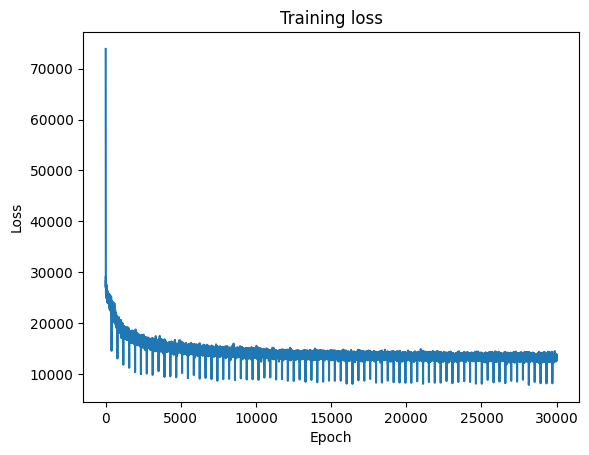

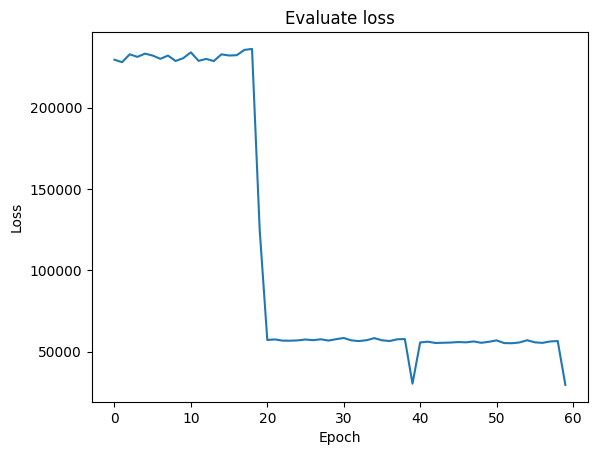

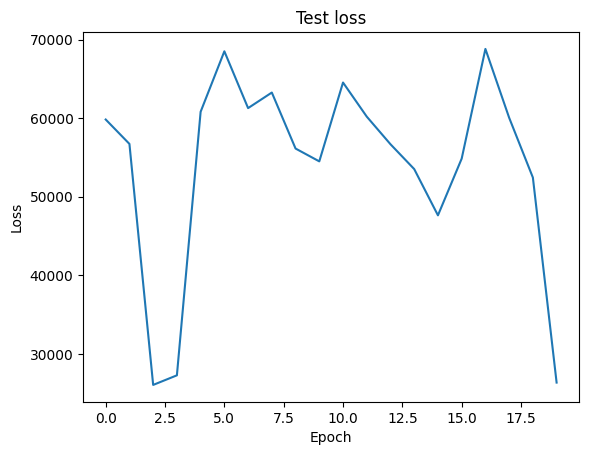

In [9]:
def plot_loss_curve(loss_hist: list, title: str):
    """
    Draw loss curves
    """
    x = range(len(loss_hist))
    plt.plot(x, loss_hist)
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()


plot_loss_curve(train_loss_hist, "Training loss")
plot_loss_curve(valid_loss_hist, "Evaluate loss")
plot_loss_curve(test_loss_hist, "Test loss")

# Parameter Visualization Distributions in Hidden Space

- We used two images to generate 2 separate 128-dimensional latent spaces as z1, z2 and drew the scatterplot.

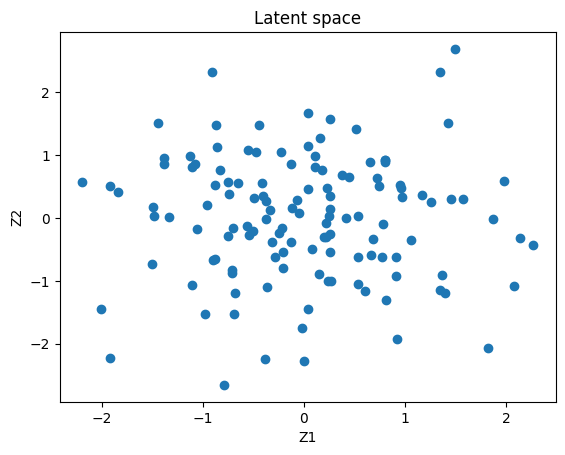

In [10]:
def plot_latent_space(z: np.ndarray, title: str) -> None:
    """
    Visually display the latent space after encoding
    """
    plt.scatter(z[0], z[1])
    plt.title(title)
    plt.xlabel('Z1')
    plt.ylabel('Z2')
    plt.show()


test_ds = cycle(test_data)
data = next(test_ds)[0][0:2, :]
with torch.no_grad():
    data = data.to(device)
    z, _ = variational(data, n_samples=1)
    plot_latent_space(z.squeeze().cpu().numpy(), "Latent space")

# Using decoder to generate images

- We used a neural network based decoder to restore the image from the hidden space and the visualization is compared to the original image as shown below.


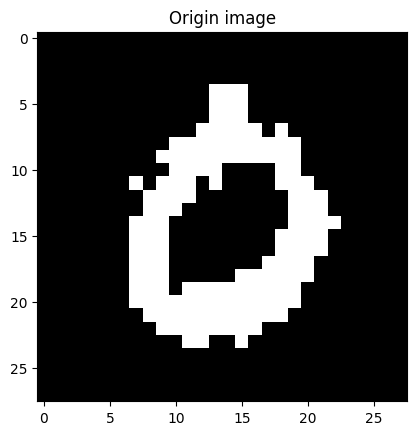

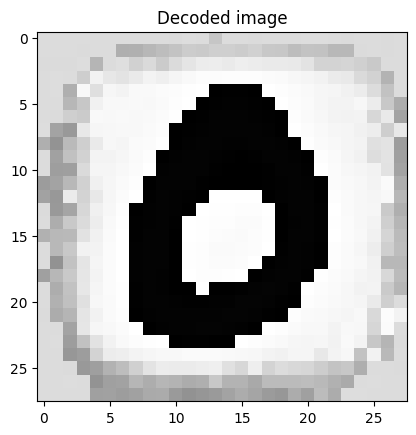

In [11]:
def plot_img(arr: np.ndarray, title: str) -> None:
    """
    Display image in grayscale mode:
     1. Convert dtype: np.float32 -> np.uint8
     2. Reshape: (784,) -> (28, 28)
     3. Display image and title
    """
    img = arr.astype(np.uint8)
    img = img.reshape((28, 28))
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.show()


test_ds = cycle(test_data)
data = next(test_ds)[0][0, :]
img_origin = data.numpy()
plot_img(img_origin, "Origin image")
with torch.no_grad():
    data = data.unsqueeze(dim=0).to(device)
    z, _ = variational(data, n_samples=1)
    output = model.decode(z)
    img_out = output.squeeze().cpu().numpy()
    plot_img(img_out, "Decoded image")


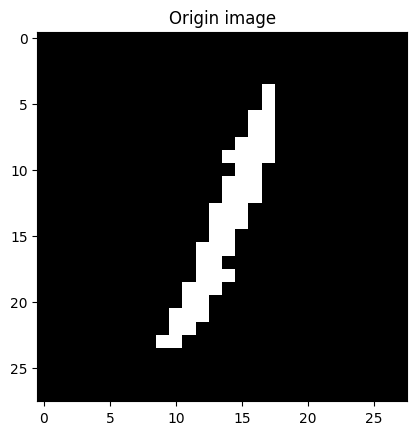

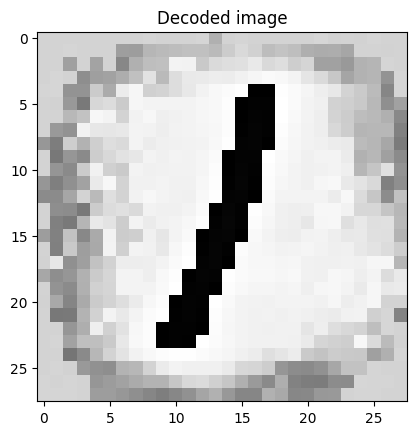

In [20]:
test_ds = cycle(test_data)
next(test_ds)
data = next(test_ds)[0][500, :]
img_origin = data.numpy()
plot_img(img_origin, "Origin image")
with torch.no_grad():
    data = data.unsqueeze(dim=0).to(device)
    z, _ = variational(data, n_samples=1)
    output = model.decode(z)
    img_out = output.squeeze().cpu().numpy()
    plot_img(img_out, "Decoded image")

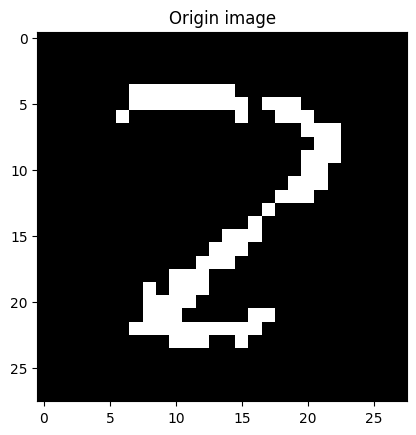

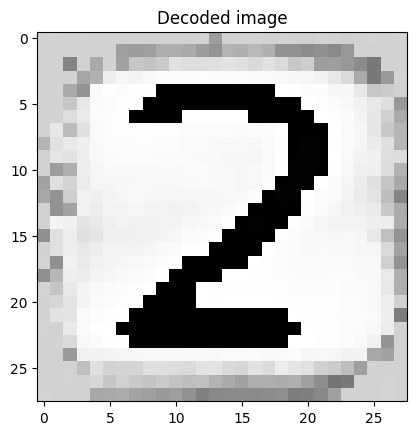

In [23]:
test_ds = cycle(test_data)
for i in range(4):
    next(test_ds)
data = next(test_ds)[0][500, :]
img_origin = data.numpy()
plot_img(img_origin, "Origin image")
with torch.no_grad():
    data = data.unsqueeze(dim=0).to(device)
    z, _ = variational(data, n_samples=1)
    output = model.decode(z)
    img_out = output.squeeze().cpu().numpy()
    plot_img(img_out, "Decoded image")

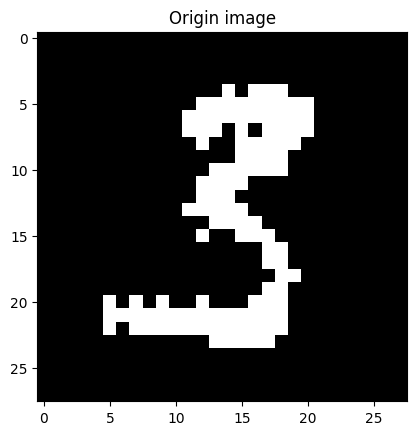

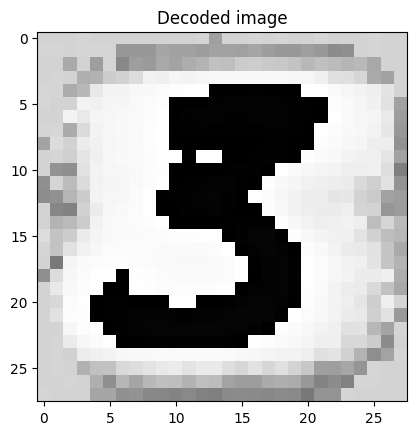

In [24]:
test_ds = cycle(test_data)
for i in range(6):
    next(test_ds)
data = next(test_ds)[0][500, :]
img_origin = data.numpy()
plot_img(img_origin, "Origin image")
with torch.no_grad():
    data = data.unsqueeze(dim=0).to(device)
    z, _ = variational(data, n_samples=1)
    output = model.decode(z)
    img_out = output.squeeze().cpu().numpy()
    plot_img(img_out, "Decoded image")

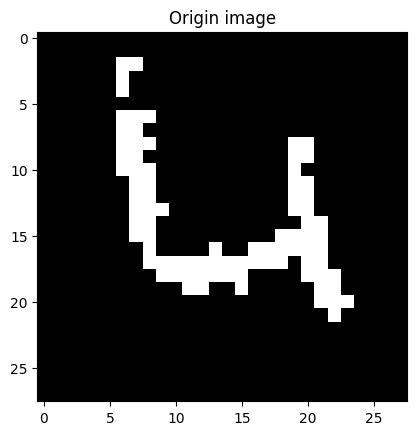

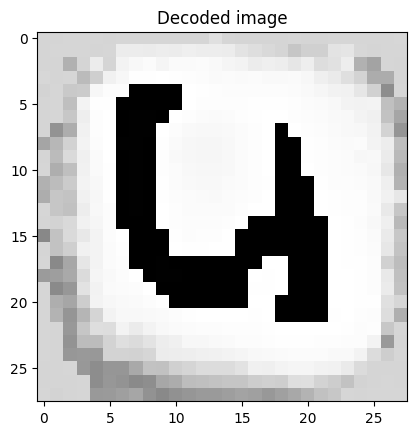

In [28]:
test_ds = cycle(test_data)
for i in range(8):
    next(test_ds)
data = next(test_ds)[0][500, :]
img_origin = data.numpy()
plot_img(img_origin, "Origin image")
with torch.no_grad():
    data = data.unsqueeze(dim=0).to(device)
    z, _ = variational(data, n_samples=1)
    output = model.decode(z)
    img_out = output.squeeze().cpu().numpy()
    plot_img(img_out, "Decoded image")

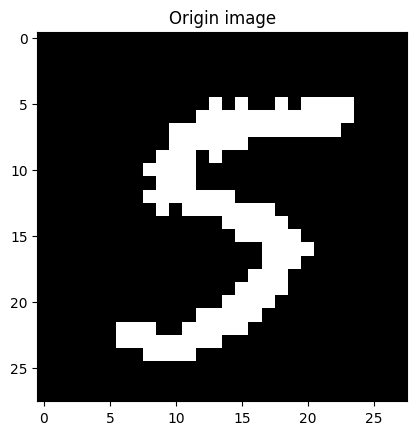

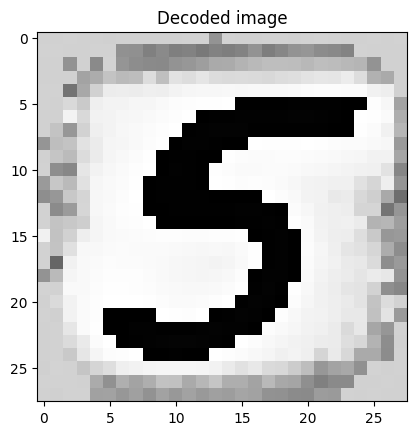

In [29]:
test_ds = cycle(test_data)
for i in range(10):
    next(test_ds)
data = next(test_ds)[0][500, :]
img_origin = data.numpy()
plot_img(img_origin, "Origin image")
with torch.no_grad():
    data = data.unsqueeze(dim=0).to(device)
    z, _ = variational(data, n_samples=1)
    output = model.decode(z)
    img_out = output.squeeze().cpu().numpy()
    plot_img(img_out, "Decoded image")

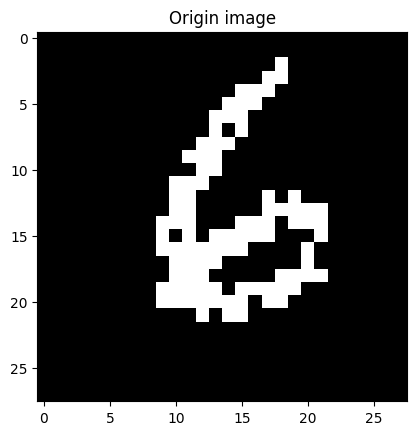

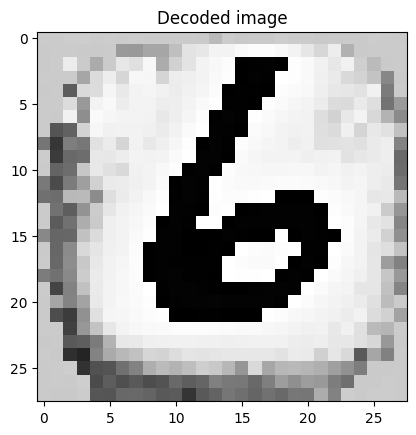

In [30]:
test_ds = cycle(test_data)
for i in range(12):
    next(test_ds)
data = next(test_ds)[0][500, :]
img_origin = data.numpy()
plot_img(img_origin, "Origin image")
with torch.no_grad():
    data = data.unsqueeze(dim=0).to(device)
    z, _ = variational(data, n_samples=1)
    output = model.decode(z)
    img_out = output.squeeze().cpu().numpy()
    plot_img(img_out, "Decoded image")

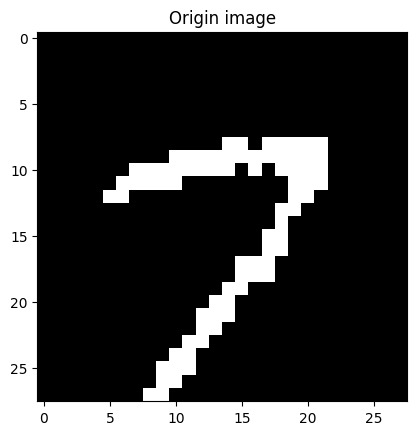

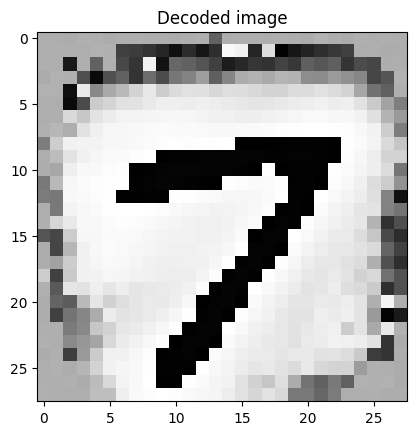

In [31]:
test_ds = cycle(test_data)
for i in range(14):
    next(test_ds)
data = next(test_ds)[0][500, :]
img_origin = data.numpy()
plot_img(img_origin, "Origin image")
with torch.no_grad():
    data = data.unsqueeze(dim=0).to(device)
    z, _ = variational(data, n_samples=1)
    output = model.decode(z)
    img_out = output.squeeze().cpu().numpy()
    plot_img(img_out, "Decoded image")

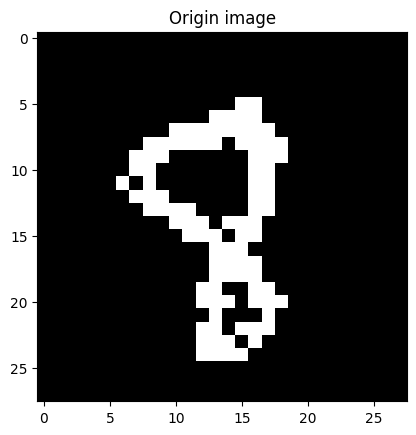

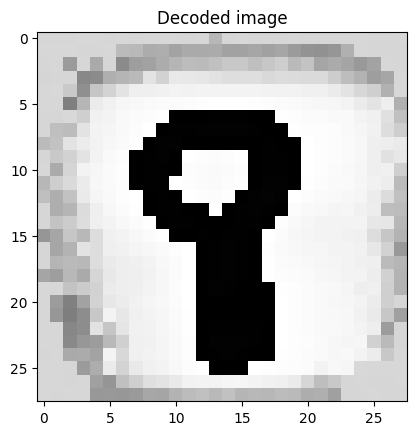

In [32]:
test_ds = cycle(test_data)
for i in range(16):
    next(test_ds)
data = next(test_ds)[0][500, :]
img_origin = data.numpy()
plot_img(img_origin, "Origin image")
with torch.no_grad():
    data = data.unsqueeze(dim=0).to(device)
    z, _ = variational(data, n_samples=1)
    output = model.decode(z)
    img_out = output.squeeze().cpu().numpy()
    plot_img(img_out, "Decoded image")

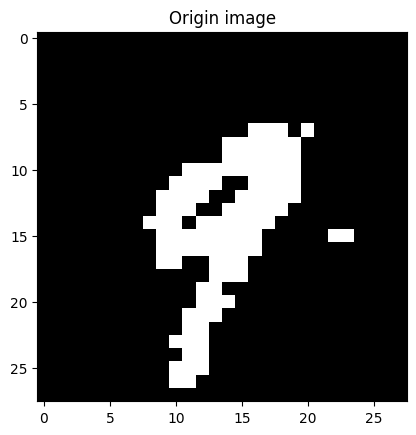

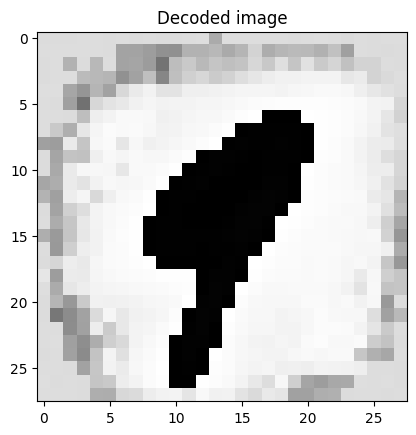

In [33]:
test_ds = cycle(test_data)
for i in range(18):
    next(test_ds)
data = next(test_ds)[0][500, :]
img_origin = data.numpy()
plot_img(img_origin, "Origin image")
with torch.no_grad():
    data = data.unsqueeze(dim=0).to(device)
    z, _ = variational(data, n_samples=1)
    output = model.decode(z)
    img_out = output.squeeze().cpu().numpy()
    plot_img(img_out, "Decoded image")